In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import appelpy

# Load data

[Dataset from University of Notre Dame](https://www3.nd.edu/~rwilliam/stats2/l25.pdf) for demonstration of **OLS** and **WLS** regression.

The dataset is very light and the schema is not all clear.  It is being used here to compare output from `appelpy` to output from Stata directly.

In [2]:
df = pd.read_stata('data/reg01.dta')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 4 columns):
income    20 non-null float32
educ      20 non-null int8
jobexp    20 non-null int8
race      20 non-null category
dtypes: category(1), float32(1), int8(2)
memory usage: 396.0 bytes


In [3]:
df.head()

,income,educ,jobexp,race
0,5.0,2,9,black
1,9.7,4,18,black
2,28.4,8,21,black
3,8.8,8,12,black
4,21.0,8,14,black


Let's examine the values of the four main statistical moments for the continuous variables in the dataset, via a function in the `eda` module.

In [4]:
appelpy.eda.statistical_moments(df)

,mean,var,skew,kurtosis
income,24.415,91.0213,0.180733,0.778104
educ,12.05,19.0475,-0.430739,0.157395
jobexp,12.65,28.3275,-0.397716,-0.828062


# OLS

## Unstandardized and standardized estimates

Let's do a straightforward OLS regression of `income` on `educ` and `jobexp` (non-robust standard errors).

The standard error is set to 'nonrobust' as a default in `appelpy`, in line with Statsmodels and Stata.

Note: Use of heteroskedasticity-robust standard errors is recommended more generally.

In [5]:
from appelpy.linear_model import OLS

In [6]:
model1 = OLS(df, ['income'], ['educ', 'jobexp'])
model1.results_output

C:\ProgramData\Miniconda3\envs\appelpy\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Model fitting in progress...
Model fitted.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     46.33
Date:                Sun, 08 Sep 2019   Prob (F-statistic):           1.31e-07
Time:                        23:01:35   Log-Likelihood:                -54.848
No. Observations:                  20   AIC:                             115.7
Df Residuals:                      17   BIC:                             118.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.0969      3.626     -1.957      0.067     -14.748       0.554
educ           1.9334      0.210      9.209      0.000       1.490       2.376
jobexp         0.6494      0.172      3.772      0.002       0.286       1.013
==============================================================================
Omnibus:                        1.339   Durbin-Watson:                   2.490
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.180
Skew:                          -0.464   Prob(JB):                        0.554
Kurtosis:                       2.256   Cond. No.                         72.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The `results_output_standardized` object contains the **standardized estimates** of the regressors (and the unstandardized ones).

Standardized coefficients are sometimes called **beta coefficients**.

The output is similar to what would be returned by Stata's _`listcoef` command_.

These are the standardized estimates listed:
- `coef_stdX`: x-standardized coefficient, i.e. how much does `y` increase with a one-standard deviation increase in `x`.
- `coef_stdXy`: fully standardized coefficient, i.e. by how many standard deviations does `y` increase with a one=standard deviation increase in `x`.
- `stdev_X`: standard deviation of regressor

In [7]:
model1.results_output_standardized

,coef,t,P>|t|,coef_stdX,coef_stdXy,stdev_X
income,,,,,,
educ,+1.9334,+9.209,0.000,+8.6572,+0.8844,4.4777
jobexp,+0.6494,+3.772,0.002,+3.5459,+0.3623,5.4606


Compare with the results from the Stata command

`reg  income educ jobexp, beta`

```
      Source |       SS       df       MS              Number of obs =      20 
-------------+------------------------------           F(  2,    17) =   46.33 
       Model |  1538.22521     2  769.112605           Prob > F      =  0.0000 
    Residual |  282.200265    17  16.6000156           R-squared     =  0.8450 
-------------+------------------------------           Adj R-squared =  0.8267 
       Total |  1820.42548    19  95.8118671           Root MSE      =  4.0743 
 
------------------------------------------------------------------------------ 
      income |      Coef.   Std. Err.      t    P>|t|                     Beta 
-------------+---------------------------------------------------------------- 
        educ |   1.933393   .2099494     9.21   0.000                 .8844385 
      jobexp |   .6493654   .1721589     3.77   0.002                 .3622612 
       _cons |  -7.096855   3.626412    -1.96   0.067                        . 
------------------------------------------------------------------------------
```

The output from the `results_output_standardized` attribute is a Pandas Styler object, so that the values can be formatted and have a level if precision that matches the `results_output` attribute.

The underlying data (a Pandas dataframe) can be accessed from the attribute itself, if needed.

In [8]:
type(model1.results_output_standardized)

pandas.io.formats.style.Styler

In [9]:
model1_std_data = model1.results_output_standardized.data
type(model1_std_data)

pandas.core.frame.DataFrame

The statement below shows how the standardized coefficients can be accessed.

In [10]:
print(f"""A one-standard deviation increase in educ is associated with a
      {model1_std_data.loc['educ', 'coef_stdX']:.4f}-unit increase in {model1_std_data.index.name}""")

A one-standard deviation increase in educ is associated with a
      8.6572-unit increase in income


We can also verify that the `coef_stdX` = `coef` * `stdev_X`

In [11]:
# LHS == RHS statement
(model1_std_data.loc['educ', 'coef_stdX'].round(4)
 ==
 (model1_std_data.loc['educ', 'stdev_X'] * model1_std_data.loc['educ', 'coef']).round(4)) # RHS

True

## Model selection

A notable omission from the Statsmodels summary table is the Root MSE (root mean square error).

The `model_selection_stats` attribute gathers important model selection statistics in one place.

In [12]:
model1.model_selection_stats

{'Root MSE': 4.074311667114434,
 'R-squared': 0.8449811508953546,
 'R-squared (adj)': 0.8267436392359846,
 'AIC': 115.69523539340607,
 'BIC': 118.68243221406804}

The Root MSE is displayed in the dictionary and is in line with the result from Stata's output.

## Prediction

Let's find the mean values for each regressor (independent variable) and predict `income` based on those values.

In [13]:
X_mean = df[['educ', 'jobexp']].mean()
X_mean

educ      12.05
jobexp    12.65
dtype: float64

In [14]:
# Create dataframe of examples to predict, using mean, max & min values:
X_demo = pd.concat([X_mean, df[['educ', 'jobexp']].max(), df[['educ', 'jobexp']].min()],
                   axis='columns').T
# Add a row with 'out-of-sample' data: [0, 0] - both values below the minima observed
X_demo = X_demo.append({'educ': 0, 'jobexp': 0}, ignore_index=True)
# Add a row with a missing value:
X_demo = X_demo.append({'educ': 12, 'jobexp': np.NaN}, ignore_index=True)

X_demo

,educ,jobexp
0,12.05,12.65
1,21.00,21.00
2,2.00,1.00
3,0.00,0.00
4,12.00,NaN


Use the `predict` method on the model object:
- By default the prediction will return NaN if any values in the example to predict are outside of the sample.
- Alternatively, `within_sample` can be set to False so that examples with values outside of the sample have predictions.

If there is a missing value for a regressor, then the prediction will return NaN.

In [15]:
model1.predict(X_demo)

array([24.41499996, 47.14106618, -2.58070401,         nan,         nan])

In [16]:
model1.predict(X_demo, within_sample=False)

array([24.41499996, 47.14106618, -2.58070401, -7.09685494,         nan])

The model's predicted value for `X_mean` is the actual mean of the `income` (as expected from OLS).

In [17]:
print(f"Predicted income for X_mean: {model1.predict(X_mean)[0]:.3f}")

Predicted income for X_mean: 24.415


In [18]:
print(f"Mean income: {df['income'].mean():.3f}")

Mean income: 24.415


## Diagnostic plots

With only 20 rows in the dataset, there is not much to see in the regression diagnostic plots.

The recipe below demonstrates how the four main plots (P-P plot, Q-Q plot, residuals vs predicted values plot, residuals vs fitted values plot) can be gathered in a 2x2 grid.

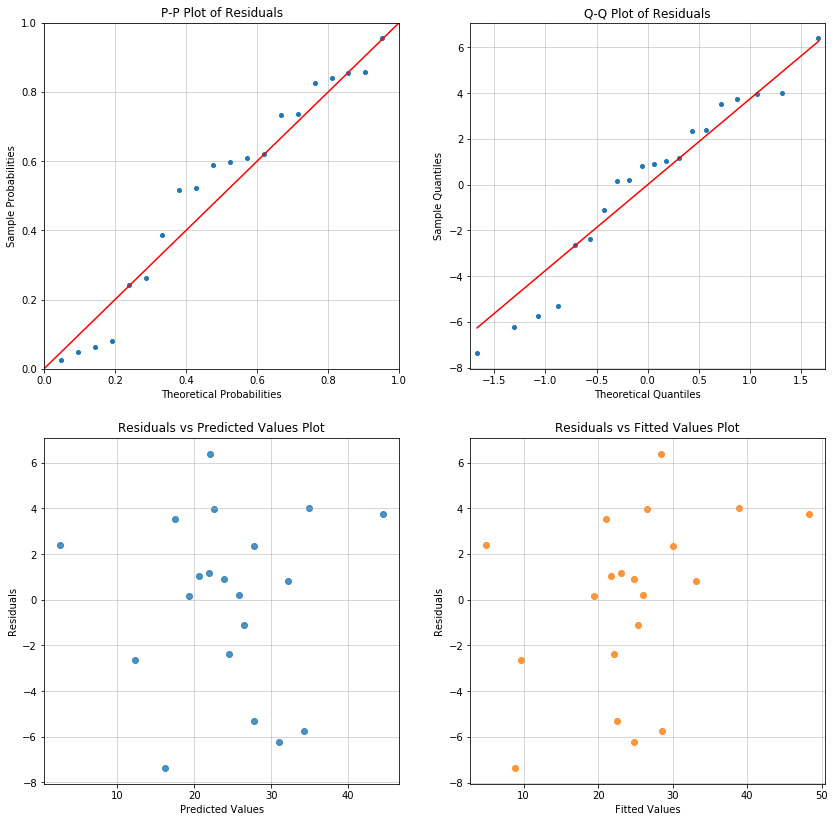

In [19]:
fig, axarr = plt.subplots(2, 2, figsize=(14,14))
model1.diagnostic_plot('pp_plot', ax=axarr[0][0])
model1.diagnostic_plot('qq_plot', ax=axarr[0][1])
model1.diagnostic_plot('rvp_plot', ax=axarr[1][0])
model1.diagnostic_plot('rvf_plot', ax=axarr[1][1])
plt.show()

# WLS

The University of Notre Dame handout for the dataset creates weights from `educ` in an attempt to reduce heteroskedasticity (based on the findings of statistical tests, as the diagnostic plots do not reveal much).

The weights array is the inverse of `educ^2`.

In [20]:
from appelpy.linear_model import WLS

In [21]:
# Set up weights
inv_educ = (1 / df['educ']) ** 2

Note that the sum of the weights sum to less than one!  This would be problematic for WLS done through Statsmodels.

In [22]:
sum(inv_educ)

0.44264763381567945

Set up model 2's specification (WLS), using `inv_educ` as weights.

In [23]:
# Pass the weights to the 'w' argument
model2 = WLS(df, ['income'], ['educ', 'jobexp'], w=inv_educ)
model2.results_output

Model fitting in progress...
Model fitted.


C:\ProgramData\Miniconda3\envs\appelpy\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.910
Model:                            WLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     86.20
Date:                Sun, 08 Sep 2019   Prob (F-statistic):           1.26e-09
Time:                        23:01:38   Log-Likelihood:                -58.220
No. Observations:                  20   AIC:                             122.4
Df Residuals:                      17   BIC:                             125.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1597      1.943     -1.626      0.122      -7.258       0.939
educ           1.7957      0.156     11.544      0.000       1.468       2.124
jobexp         0.4588      0.163      2.817      0.012       0.115       0.802
==============================================================================
Omnibus:                        1.882   Durbin-Watson:                   3.135
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                0.522
Skew:                          -0.196   Prob(JB):                        0.770
Kurtosis:                       3.687   Cond. No.                         39.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

```gen inveduc = (1/educ)^2```

```reg income educ jobexp [aw = inveduc]```

```
(sum of wgt is 4.4265e-01)
      Source |       SS      df       MS               Number of obs =      20
-------------+------------------------------           F(  2,    17) =   86.20
       Model |  1532.21449    2   766.107244           Prob > F      =  0.0000
    Residual |  151.090319   17   8.88766581           R-squared     =  0.9102
-------------+------------------------------           Adj R-squared =  0.8997
       Total |  1683.30481   19   88.5949898           Root MSE      =  2.9812
------------------------------------------------------------------------------
      income |      Coef.   Std. Err.    t      P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       educ  |   1.795724   .1555495   11.54    0.000     1.467544    2.123905
      jobexp |   .4587992   .1628655    2.82    0.012      .115183    .8024155
       _cons |  -3.159669   1.94267    -1.63    0.122    -7.258345    .9390065
------------------------------------------------------------------------------
```

In [24]:
model2.results_output_standardized

,coef,t,P>|t|,coef_stdX,coef_stdXy,stdev_X
income,,,,,,
educ,+1.7957,+11.544,0.000,+7.1368,+0.8729,3.9743
jobexp,+0.4588,+2.817,0.012,+1.7415,+0.2130,3.7958


# Heteroskedasticity

In [25]:
from appelpy.diagnostics import heteroskedasticity_test

The `heteroskedasticity_test` supports two tests:
- **`breusch_pagan`**: test can be done on all regressors, or even a subset of regressors (kwarg `regressors_subset` is optional).
- **`white`**: test done on all the model's regressors.  A general test for heteroskedasticity.

In [26]:
test_stat, p_value = heteroskedasticity_test('breusch_pagan', model1)
print(f'Breusch-Pagan test stat: {test_stat:.4f}')
print(f'p-value: {p_value:.4f}')

Breusch-Pagan test stat: 0.1248
p-value: 0.7238


Compare with the results from the Stata command `hettest`

```
Breusch-Pagan / Cook-Weisberg test for heteroskedasticity
        Ho: Constant variance
        Variables: fitted values of income
        
        chi2(1) = 0.12
        Prob > chi2 = 0.7238
```

In [27]:
test_stat, p_value = heteroskedasticity_test('white', model1)
print(f'White test stat: {test_stat:.4f}')
print(f'p-value: {p_value:.4f}')

White test stat: 8.9777
p-value: 0.1100


Compare with the results from the Stata command `imtest, white`
```
White's test for Ho: homoskedasticity
        against Ha: unrestricted heteroskedasticity
        
        chi2(5) = 8.98
        Prob > chi2 = 0.1100
```